# read SolO cdf data, convert and plot




In [1]:
#update heliosat
#!pip install heliosat==0.4.9
#install 0.5.0 from github

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [3]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle

import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import heliosat


from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML


########### make directories first time if not there

resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

indexdir='icmecat/indices_icmecat' 
if os.path.isdir(indexdir) == False: os.mkdir(indexdir) 

catdir='icmecat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

icplotsdir='icmecat/plots_icmecat/' 
if os.path.isdir(icplotsdir) == False: os.mkdir(icplotsdir) 

plt.rcParams["figure.figsize"] = (15,5)


from astropy.constants import au
#define AU in km
AU=au.value/1e3
print('done')
print(heliosat.__version__)

done
0.5.0


## read all public SolO MAG data and convert to recarray and to other coordinate systems


In [20]:
#normal time resolution
#DATAPATH = "/nas/helio/data/SolarOrbiter/MAG/level2/mag_rtn_norm"

#1 minute time resolution
DATAPATH = "/nas/helio/data/SolarOrbiter/MAG/level2/mag_rtn_norm_1min"

class SOLO_EXT(heliosat.SOLO):
    
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()

        files = [os.path.join(DATAPATH, f) for f in files]
        print(files)
        return files, [self.get_data_version("mag", datetime.datetime.now())] * len(files)
  

a = SOIO_EXT()

In [21]:
#old total_days=90 time = [datetime.datetime(2020, 6, 1) + datetime.timedelta(minutes=i) for i in range(total_days * 24 * 60 )]

#time 
t_solort=datetime.datetime(2020, 6,1,tzinfo=datetime.timezone.utc)
t_end=datetime.datetime(2020, 10, 27,tzinfo=datetime.timezone.utc)


#t_solort=datetime.datetime(2020, 6,1)
#t_end=datetime.datetime(2020, 10, 27)



#make 1 min datetimes
t_solort1=copy.deepcopy(t_solort)
time_1=[]
while t_solort1 < t_end:
    time_1.append(t_solort1)  
    t_solort1 += datetime.timedelta(minutes=1)

time_mat=mdates.date2num(time_1) 

#_, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ")

# t_soio = [datetime.datetime(2020, 5, 27) + datetime.timedelta(hours=i) for i in range(24 * 7)]
# _, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ", cache=True, smoothing="kernel",
#                                 smoothing_scale=240, remove_nans=True)

print('get data')
t2, b_soio = SOLO_EXT().get_data(time_1, "mag")#,frame='HEEQ')
t1=parse_time(t2,format='unix').datetime
tm_mat=mdates.date2num(t1) 

smag=np.zeros(np.size(time_1),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),\
        ('vt', float),('np', float), ('tp', float),\
                                   ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
smag = smag.view(np.recarray) 

print('interpolate')
smag.time=time_1
smag.bx = np.interp(time_mat, tm_mat, b_soio[:, 0])
smag.by = np.interp(time_mat, tm_mat, b_soio[:, 1])
smag.bz = np.interp(time_mat, tm_mat, b_soio[:, 2])
smag.bt =np.sqrt(smag.bx**2+smag.by**2+smag.bz**2)

#round first each original time to full minutes
tround=copy.deepcopy(t1)
format_str = '%Y-%m-%d %H:%M'  
for k in np.arange(np.size(t2)):
     tround[k] = datetime.datetime.strptime(datetime.datetime.strftime(t1[k], format_str), format_str) 
tm_round=parse_time(tround).plot_date

isin=np.isin(time_mat,tm_round)      
setnan=np.where(isin==False)
#set to to nan that is not in original data
smag.bx[setnan]=np.nan
smag.by[setnan]=np.nan
smag.bz[setnan]=np.nan
smag.bt = np.sqrt(smag.bx**2+smag.by**2+smag.bz**2)



# plt.figure(1,dpi=200)
# plt.plot(tm_mat, b_soio[:, 0],lw=0.1)
# plt.plot(smag.time, smag.bx,lw=0.1)

get data


TypeError: get_data_files() got an unexpected keyword argument 'force_download'

In [5]:
print('Solo position')
#old with heliopy #add position
frame='HEEQ'
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(smag.time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[smag.r, smag.lat, smag.lon]=hd.cart2sphere(solo.x,solo.y,solo.z)



t_snap_solo = datetime.datetime(2020, 4, 19, 5, 6)
solo_pos = heliosat.SOLO().trajectory(t_snap_solo, frame="HEEQ")
print("solo lon: ", np.arctan2(solo_pos[1], solo_pos[0]) * 360 / 2 / np.pi)
print("solo lat: ", np.arctan2(solo_pos[2], solo_pos[0]) * 360 / 2 / np.pi)
t_snap_wind = datetime.datetime(2020, 4, 20, 1, 34)
wind_pos = heliosat.WIND().trajectory(t_snap_wind, frame="HEEQ")
print("wind lon: ", np.arctan2(wind_pos[1], wind_pos[0]) * 360 / 2 / np.pi)
print("wind lat: ", np.arctan2(wind_pos[2], wind_pos[0]) * 360 / 2 / np.pi)
t_snap_bepi = datetime.datetime(2020, 4, 20, 3, 9)
bepi_pos = heliosat.BEPI().trajectory(t_snap_bepi, frame="HEEQ")
print("bepi lon: ", np.arctan2(bepi_pos[1], bepi_pos[0]) * 360 / 2 / np.pi)
print("bepi lat: ", np.arctan2(bepi_pos[2], bepi_pos[0]) * 360 / 2 / np.pi)


#convert to degree
smag.lat=np.rad2deg(smag.lat)
smag.lon=np.rad2deg(smag.lon)

smag.x=solo.x.value
smag.y=solo.y.value
smag.z=solo.z.value


#------------------------------------- save

filemag=data_path+'solo_2020_june_october_rtn.p'
pickle.dump(smag, open(filemag, "wb"))

solo_sceq=hd.convert_RTN_to_SCEQ(smag,'SolO')
filemag=data_path+'solo_2020_june_october_sceq.p'
pickle.dump(solo_sceq, open(filemag, "wb"))

solo_heeq=hd.convert_RTN_to_HEEQ(smag,'SolO')
filemag=data_path+'solo_2020_june_october_heeq.p'
pickle.dump(solo_heeq, open(filemag, "wb"))

solo_gse=hd.convert_HEEQ_to_GSE(solo_heeq)
filemag=data_path+'solo_2020_june_october_gse.p'
pickle.dump(solo_gse, open(filemag, "wb"))

print('done')

KeyboardInterrupt: 

## read non public SOLO CSV data for April event (now public)

In [4]:
#1 minute time resolution
DATAPATH = "/nas/helio/data/SolarOrbiter/MAG/level2/"
file='mag_data_new_april.csv'


mnew=pd.read_csv(DATAPATH+file)
m=mnew.to_numpy()


smag=np.zeros(len(m),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),\
        ('vt', float),('np', float), ('tp', float),\
                                   ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
smag = smag.view(np.recarray) 


for i in np.arange(0,len(m)):
    smag.time[i]=parse_time(m[i,0][0:19]).datetime

smag.bt=m[:,1]
smag.bx=m[:,2]
smag.by=m[:,3]
smag.bz=m[:,4]



print('Solo position')
frame='HEEQ'
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(smag.time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[smag.r, smag.lat, smag.lon]=hd.cart2sphere(solo.x,solo.y,solo.z)

#convert to degree
smag.lat=np.rad2deg(smag.lat)
smag.lon=np.rad2deg(smag.lon)

smag.x=solo.x.value
smag.y=solo.y.value
smag.z=solo.z.value


#------------------------------------- save

filemag=data_path+'solo_2020_icme_april_rtn.p'
pickle.dump(smag, open(filemag, "wb"))

solo_sceq=hd.convert_RTN_to_SCEQ(smag,'SolO')
filemag=data_path+'solo_2020_icme_april_sceq.p'
pickle.dump(solo_sceq, open(filemag, "wb"))

solo_heeq=hd.convert_RTN_to_HEEQ(smag,'SolO')
filemag=data_path+'solo_2020_icme_april_heeq.p'
pickle.dump(solo_heeq, open(filemag, "wb"))

solo_gse=hd.convert_HEEQ_to_GSE(solo_heeq)
filemag=data_path+'solo_2020_icme_april_gse.p'
pickle.dump(solo_gse, open(filemag, "wb"))

print('done')

Solo position
RTN to SCEQ
conversion RTN to HEEQ
conversion RTN to HEEQ done
conversion HEEQ to GSE
conversion HEEQ to GSE done
done


(737533.0, 737537.0)

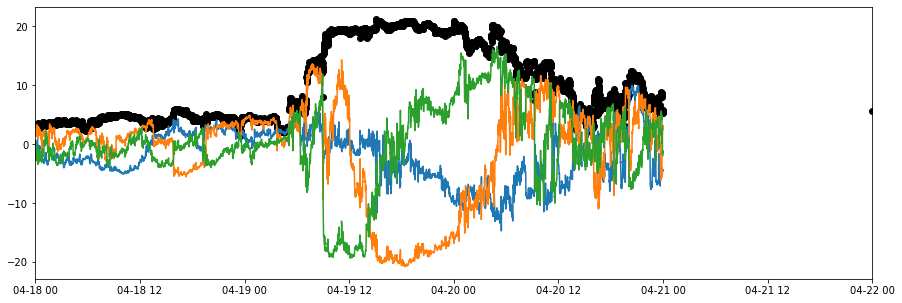

In [5]:
#file=data_path+'solo_2020_icme_april_rtn.p'
file=data_path+'solo_2020_icme_april_rtn.p'
#file=data_path+'solo_2020_april_august_rtn.p'
o=pickle.load(open(file, "rb" ) )  
plt.plot(o.time,o.bt,'ok')
plt.plot(o.time,o.bx)
plt.plot(o.time,o.by)
plt.plot(o.time,o.bz)

plt.xlim([datetime.datetime(2020,4,18),datetime.datetime(2020,4,22)])

## read non public SOLO CSV data for May event

In [6]:

#normal time resolution
#DATAPATH = "/nas/helio/data/SolarOrbiter/MAG/level2/mag_rtn_norm"

#1 minute time resolution
DATAPATH = "data/solo_mag/event2"


class SOIO_EXT(heliosat.SOIO):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files]
        return files, [self.get_data_version("mag", datetime.datetime.now())] * len(files)
  

a = SOIO_EXT()
#time for 5 days
days1=5
time = [datetime.datetime(2020, 5, 27) + datetime.timedelta(minutes=i) for i in range(days1 * 24 * 60 )]
time_mat=mdates.date2num(time) 


#_, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ")

# t_soio = [datetime.datetime(2020, 5, 27) + datetime.timedelta(hours=i) for i in range(24 * 7)]
# _, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ", cache=True, smoothing="kernel",
#                                 smoothing_scale=240, remove_nans=True)

print('get data')
t2, b_soio = SOIO_EXT().get_data(time, "mag")#,frame="HEEQ")
t1=parse_time(t2,format='unix').datetime
tm_mat=mdates.date2num(t1) 

smag=np.zeros(np.size(time),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),\
        ('vt', float),('np', float), ('tp', float),\
                                   ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
smag = smag.view(np.recarray) 

print('interpolate')
smag.time=time
smag.bx = np.interp(time_mat, tm_mat, b_soio[:, 0])
smag.by = np.interp(time_mat, tm_mat, b_soio[:, 1])
smag.bz = np.interp(time_mat, tm_mat, b_soio[:, 2])
smag.bt =np.sqrt(smag.bx**2+smag.by**2+smag.bz**2)


print('Solo position')
#add position
frame='HEEQ'
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(smag.time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[smag.r, smag.lat, smag.lon]=hd.cart2sphere(solo.x,solo.y,solo.z)

#convert to degree
smag.lat=np.rad2deg(smag.lat)
smag.lon=np.rad2deg(smag.lon)

smag.x=solo.x.value
smag.y=solo.y.value
smag.z=solo.z.value




#------------------------------------- save

filemag=data_path+'solo_2020_icme_may_rtn.p'
pickle.dump(smag, open(filemag, "wb"))


solo_sceq=hd.convert_RTN_to_SCEQ(smag,'SolO')
filemag=data_path+'solo_2020_icme_may_sceq.p'
pickle.dump(solo_sceq, open(filemag, "wb"))


solo_heeq=hd.convert_RTN_to_HEEQ(smag,'SolO')
filemag=data_path+'solo_2020_icme_may_heeq.p'
pickle.dump(solo_heeq, open(filemag, "wb"))


solo_gse=hd.convert_HEEQ_to_GSE(solo_heeq)
filemag=data_path+'solo_2020_icme_may_gse.p'
pickle.dump(solo_gse, open(filemag, "wb"))

print('done')

get data
The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
interpolate
Solo position
RTN to SCEQ
conversion RTN to HEEQ
conversion RTN to HEEQ done
conversion HEEQ to GSE
conversion HEEQ to GSE done
done


## Merge different data files RTN

SolO science data merging
solo merging done


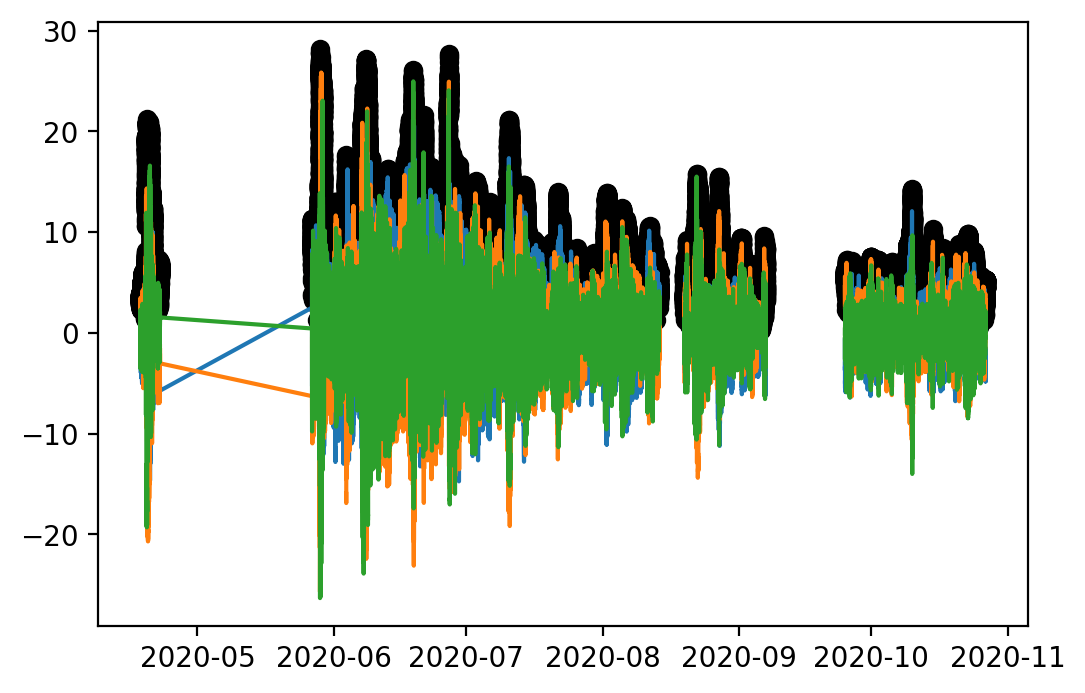

In [13]:
print('SolO science data merging')

filesolo0="solo_2020_icme_april_rtn.p"
solo0=pickle.load(open(data_path+filesolo0, "rb" ) )  

filesolo1="solo_2020_icme_may_rtn.p" 
solo1=pickle.load(open(data_path+filesolo1, "rb" ) )  

filesolo2="solo_2020_june_october_rtn.p" 
solo2=pickle.load(open(data_path+filesolo2, "rb" ) )  


#make array
solo=np.zeros(np.size(solo0.time)+np.size(solo1.time)+np.size(solo2.time),dtype=[('time',object),('bx', float),('by', float),\
            ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
            ('x', float),('y', float),('z', float),\
            ('r', float),('lat', float),('lon', float)])   

#convert to recarray
solo = solo.view(np.recarray)  
solo.time=np.hstack((solo0.time,solo1.time,solo2.time))
solo.bx=np.hstack((solo0.bx,solo1.bx,solo2.bx))
solo.by=np.hstack((solo0.by,solo1.by,solo2.by))
solo.bz=np.hstack((solo0.bz,solo1.bz,solo2.bz))
solo.bt=np.hstack((solo0.bt,solo1.bt,solo2.bt))
solo.vt=np.hstack((solo0.vt,solo1.vt,solo2.vt))
solo.np=np.hstack((solo0.np,solo1.np,solo2.np))
solo.tp=np.hstack((solo0.tp,solo1.tp,solo2.tp))
solo.x=np.hstack((solo0.x,solo1.x,solo2.x))
solo.y=np.hstack((solo0.y,solo1.y,solo2.y))
solo.z=np.hstack((solo0.z,solo1.z,solo2.z))
solo.r=np.hstack((solo0.r,solo1.r,solo2.r))
solo.lon=np.hstack((solo0.lon,solo1.lon,solo2.lon))
solo.lat=np.hstack((solo0.lat,solo1.lat,solo2.lat))

file='solo_2020_april_october_rtn.p'
pickle.dump(solo, open(data_path+file, "wb"))
print('solo merging done')



#file="solo_2020_icme_april_rtn.p"
solo1=pickle.load(open(data_path+file, "rb" ) )  


plt.figure(1,dpi=200)
#plt.plot(solo1.time,solo1.vt)
plt.plot(solo1.time,solo1.bt,'ok')
plt.plot(solo1.time,solo1.bx)
plt.plot(solo1.time,solo1.by)
plt.plot(solo1.time,solo1.bz)

## Merge different data files SCEQ

In [8]:

%matplotlib

print('SolO science data merging')

filesolo0="solo_2020_icme_april_sceq.p"
solo0=pickle.load(open(data_path+filesolo0, "rb" ) )  

filesolo1="solo_2020_icme_may_sceq.p" 
solo1=pickle.load(open(data_path+filesolo1, "rb" ) )  

filesolo2="solo_2020_june_october_sceq.p" 
solo2=pickle.load(open(data_path+filesolo2, "rb" ) )  


#make array
solo=np.zeros(np.size(solo0.time)+np.size(solo1.time)+np.size(solo2.time),dtype=[('time',object),('bx', float),('by', float),\
            ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
            ('x', float),('y', float),('z', float),\
            ('r', float),('lat', float),('lon', float)])   

#convert to recarray
solo = solo.view(np.recarray)  
solo.time=np.hstack((solo0.time,solo1.time,solo2.time))
solo.bx=np.hstack((solo0.bx,solo1.bx,solo2.bx))
solo.by=np.hstack((solo0.by,solo1.by,solo2.by))
solo.bz=np.hstack((solo0.bz,solo1.bz,solo2.bz))
solo.bt=np.hstack((solo0.bt,solo1.bt,solo2.bt))
solo.vt=np.hstack((solo0.vt,solo1.vt,solo2.vt))
solo.np=np.hstack((solo0.np,solo1.np,solo2.np))
solo.tp=np.hstack((solo0.tp,solo1.tp,solo2.tp))
solo.x=np.hstack((solo0.x,solo1.x,solo2.x))
solo.y=np.hstack((solo0.y,solo1.y,solo2.y))
solo.z=np.hstack((solo0.z,solo1.z,solo2.z))
solo.r=np.hstack((solo0.r,solo1.r,solo2.r))
solo.lon=np.hstack((solo0.lon,solo1.lon,solo2.lon))
solo.lat=np.hstack((solo0.lat,solo1.lat,solo2.lat))

file='solo_2020_april_october_sceq.p'
pickle.dump(solo, open(data_path+file, "wb"))
print('solo merging done')



#file="solo_2020_icme_april_rtn.p"
solo1=pickle.load(open(data_path+file, "rb" ) )  


plt.figure(1,dpi=200)
#plt.plot(solo1.time,solo1.vt)
plt.plot(solo1.time,solo1.bt)
plt.plot(solo1.time,solo1.bx)
plt.plot(solo1.time,solo1.by)
plt.plot(solo1.time,solo1.bz)





Using matplotlib backend: agg
SolO science data merging
solo merging done


In [9]:
%matplotlib 
hp.plot_insitu_measure_mag(solo1, '2020-Aug-25','2020-Oct-30', 'SolarOrbiter', 'results/plots_icmecat/')



        
        

Using matplotlib backend: agg


IndexError: index 0 is out of bounds for axis 0 with size 0

## checks

In [10]:
#consistency check RTN to HEEQ to RTN - works!
from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

filemag=data_path+'solo_2020_june_july_rtn.p'
solortn=pickle.load(open(filemag, "rb" ) ) 

soloheeq=hd.convert_RTN_to_HEEQ(solortn,'Solo')

solortnc=hd.convert_HEEQ_to_RTN(soloheeq)

conversion RTN to HEEQ
conversion RTN to HEEQ done
conversion HEEQ to RTN
conversion HEEQ to RTN done


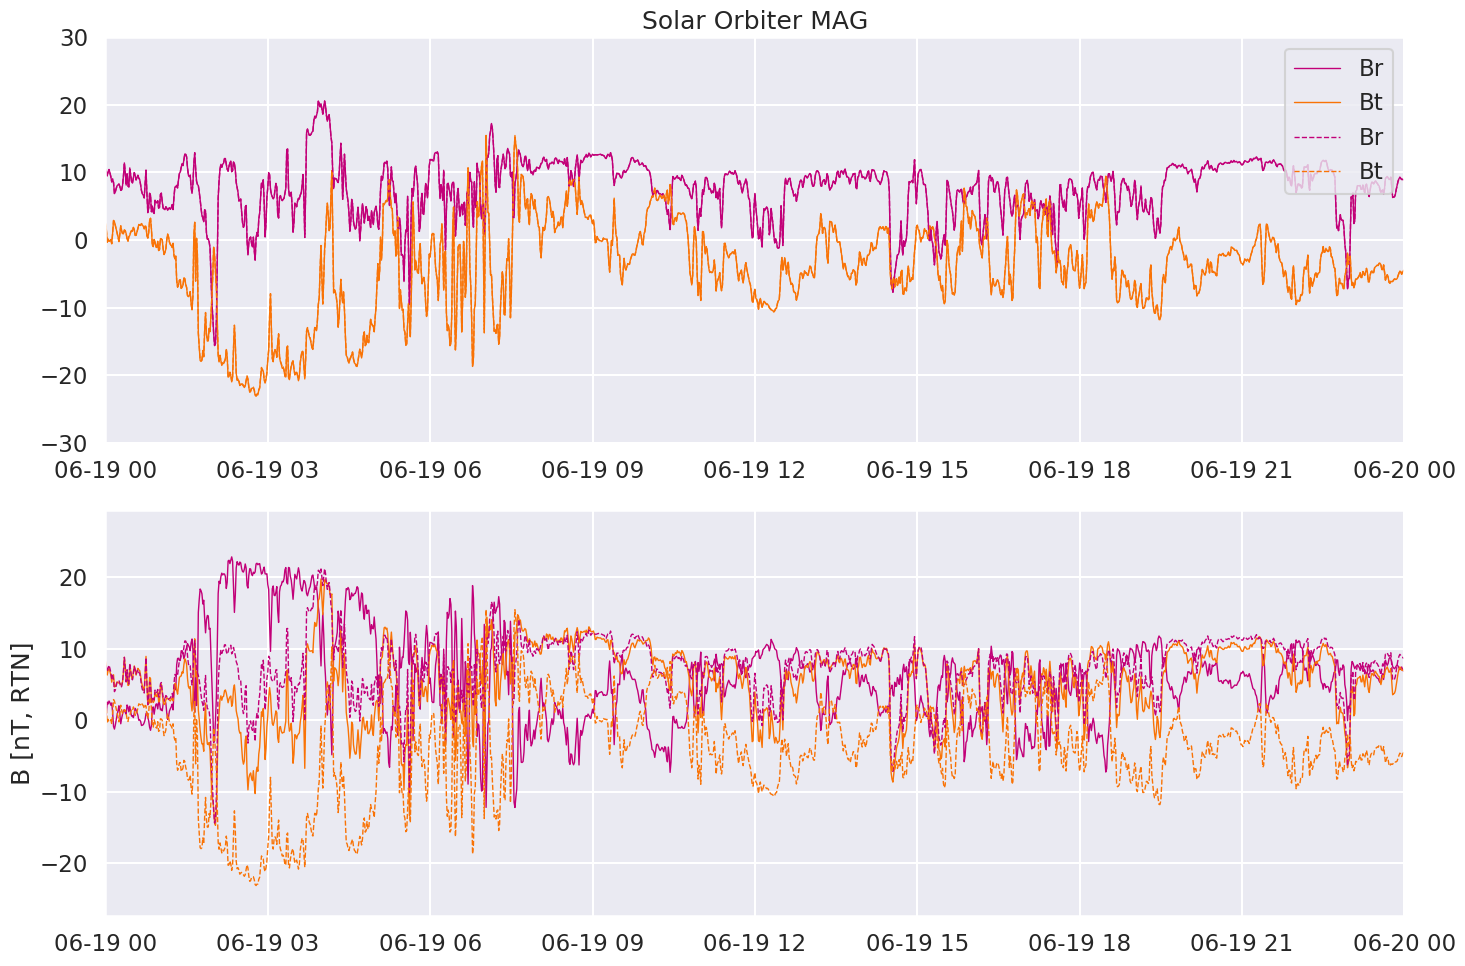

In [15]:
filemag=data_path+'solo_2020_june_july_sceq.p'
solosceq=pickle.load(open(filemag, "rb" ) )

filemag=data_path+'solo_2020_june_july_heeq.p'
soloheeq=pickle.load(open(filemag, "rb" ) )


%matplotlib inline
sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(1,figsize=(15, 10),dpi=100)

ax = plt.subplot(211)
plt.title('Solar Orbiter MAG')

##              1 check for rtn to heeq to rtn
#ax.plot(solortn.time, solortn.bt, "k-", lw=1, label='Btotal')
ax.plot(solortn.time, solortn.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax.plot(solortn.time, solortn.by, "g-", color="xkcd:orange", lw=1,label='Bt')
#ax.plot(solortn.time, solortn.bz, "b-", color="xkcd:azure", lw=1,label='Bn')

#ax.plot(solortnc.time, solortnc.bt, "k--", lw=1, label='Btotal')
ax.plot(solortnc.time, solortnc.bx, "r--", color="xkcd:magenta", lw=1, label='Br')
ax.plot(solortnc.time, solortnc.by, "g--", color="xkcd:orange", lw=1,label='Bt')
#ax.plot(solortnc.time, solortnc.bz, "b--", color="xkcd:azure", lw=1,label='Bn')


ax1 = plt.subplot(212)

#######         check for sceq different to HEEQ, depending on longitude
#ax.plot(solortn.time, solortn.bt, "k-", lw=1, label='Btotal')
ax1.plot(soloheeq.time, soloheeq.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(soloheeq.time, soloheeq.by, "g-", color="xkcd:orange", lw=1,label='Bt')
#ax.plot(solortn.time, solortn.bz, "b-", color="xkcd:azure", lw=1,label='Bn')

#ax.plot(solortnc.time, solortnc.bt, "k--", lw=1, label='Btotal')
ax1.plot(solosceq.time, solosceq.bx, "r--", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(solosceq.time, solosceq.by, "g--", color="xkcd:orange", lw=1,label='Bt')
#ax.plot(solortnc.time, solortnc.bz, "b--", color="xkcd:azure", lw=1,label='Bn')


plt.ylabel('B [nT, RTN]')
ax.set_ylim([-30,30])
ax.legend(loc=1)


plotsolort=datetime.datetime(2020, 6, 19)
plotend=datetime.datetime(2020, 6,20)
ax.set_xlim(plotsolort,plotend)
ax1.set_xlim(plotsolort,plotend)

plt.tight_layout()



check heeq to gse - works


In [26]:
from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

filewin=data_path+'wind_2018_2020_oct_gse.p'
[wing,hwin]=pickle.load(open(filewin, "rb" ) )

filewin=data_path+'wind_2018_2020_oct_heeq.p'
[winq,hwin]=pickle.load(open(filewin, "rb" ) )

win2=hd.convert_HEEQ_to_GSE(winq)

conversion HEEQ to GSE
conversion HEEQ to GSE done


6.639755737547154e-18
-1.8948446618879653e-17
-1.2780874147821885e-17


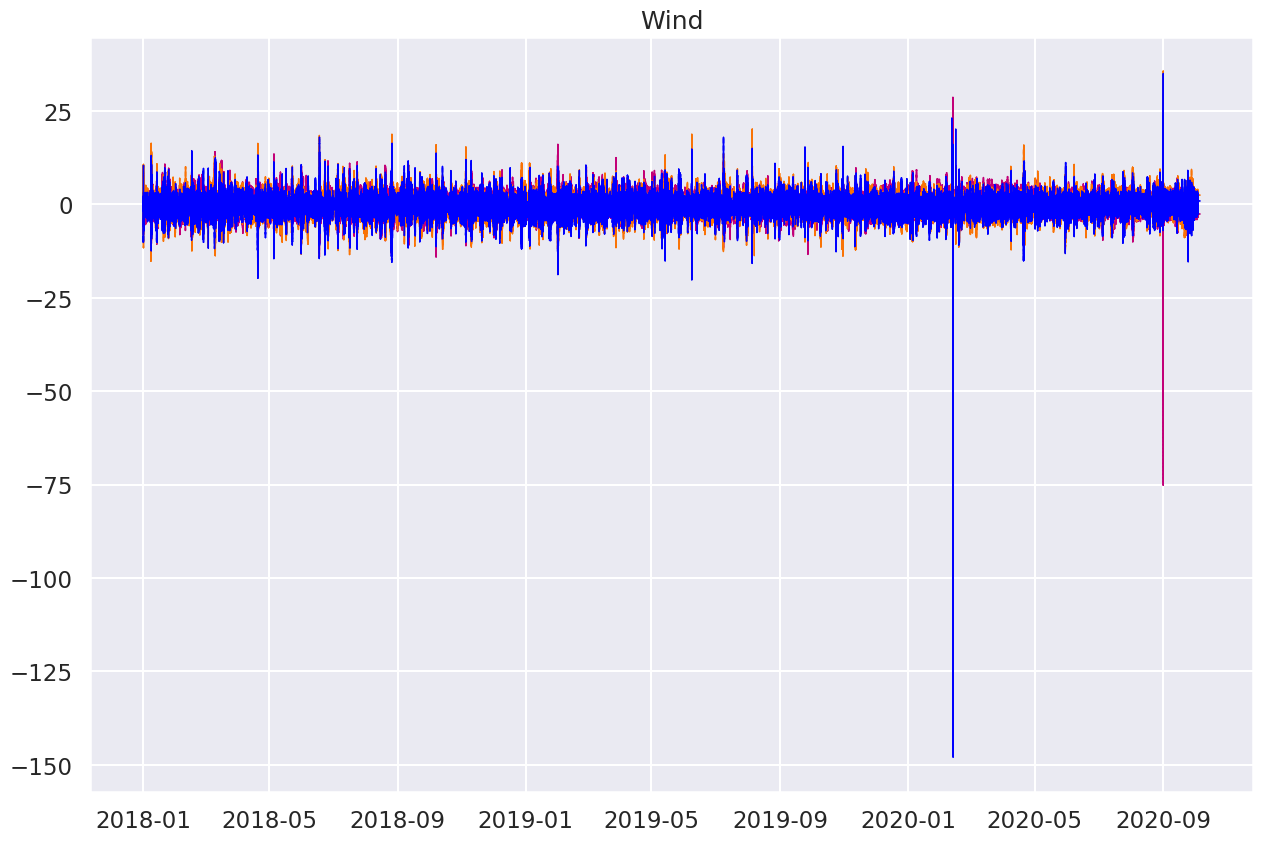

In [29]:
%matplotlib inline
sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(1,figsize=(15, 10),dpi=100)

ax = plt.subplot(111)
plt.title('Wind')

##              1 check for gse to heeq to gse
#ax.plot(solortn.time, solortn.bt, "k-", lw=1, label='Btotal')
ax.plot(win2.time, win2.bx, "r--", color="xkcd:magenta", lw=1, label='Br HEEQ2GSE')
ax.plot(win2.time, win2.by, "g--", color="xkcd:orange", lw=1,label='Bt HEEQ2GSE')
ax.plot(win2.time, win2.bz, "b--", lw=1,label='Bn HEEQ2GSE')


#ax.plot(solortn.time, solortn.bt, "k-", lw=1, label='Btotal')
ax.plot(wing.time, wing.bx, "r-", color="xkcd:magenta", lw=1, label='Br GSE')
ax.plot(wing.time, wing.by, "g-", color="xkcd:orange", lw=1,label='Bt GSE')
ax.plot(wing.time, wing.bz, "b-", lw=1,label='Bn GSE')

print(np.nanmean(wing.bx-win2.bx))
print(np.nanmean(wing.by-win2.by))
print(np.nanmean(wing.bz-win2.bz))


## Plot all data

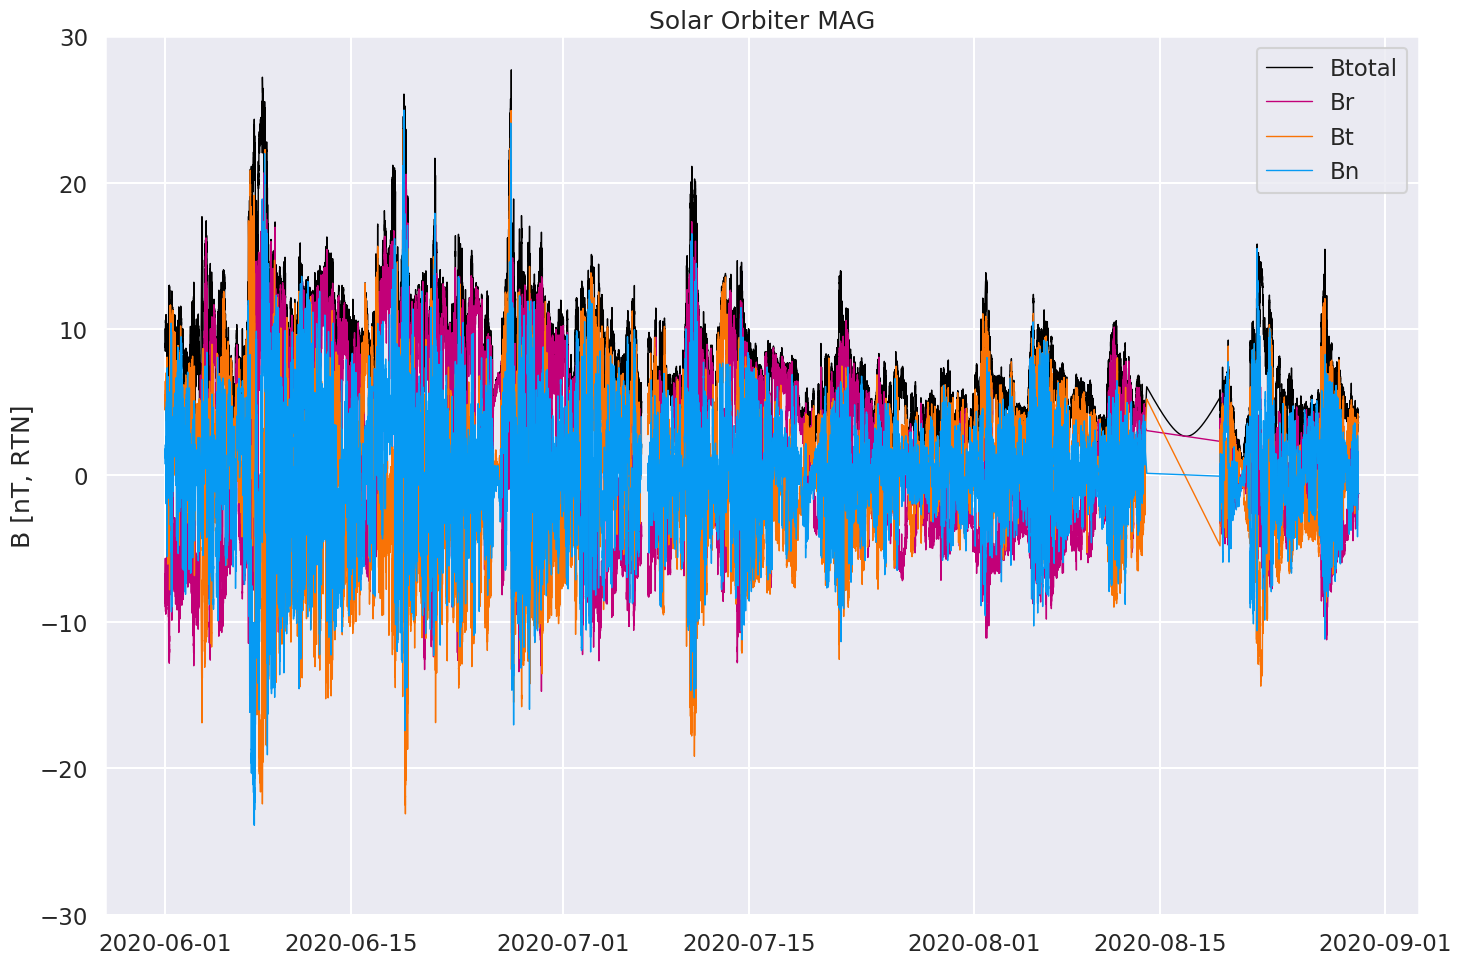

In [2]:
%matplotlib inline
#%matplotlib 


filemag=data_path+'solo_2020_june_august_rtn.p'
sm=pickle.load(open(filemag, "rb" ) ) 

#filewin=data_path+'wind_2018_now_heeq.p'
#[win,hwin]=pickle.load(open(filewin, "rb" ) )

sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(1,figsize=(15, 10),dpi=100)

ax = plt.subplot(111)
plt.title('Solar Orbiter MAG')
ax.plot(sm.time, sm.bt, "k-", lw=1, label='Btotal')
ax.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
plt.ylabel('B [nT, RTN]')
ax.set_ylim([-30,30])
ax.legend(loc=1)


plt.tight_layout()



plt.savefig('results/solo_june_august2020.png',dpi=100)

## Extra event 1

In [3]:
#normal time resolution
#DATAPATH = "/nas/helio/data/SolarOrbiter/MAG/level2/mag_rtn_norm"

#1 minute time resolution
DATAPATH = "data/solo_mag/event1"


class SOIO_EXT(heliosat.SOIO):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files]
        return files, [self.get_data_version("mag", datetime.datetime.now())] * len(files)
  

a = SOIO_EXT()
#time for 7 days
time = [datetime.datetime(2020, 4, 15) + datetime.timedelta(minutes=i) for i in range(8 * 24 * 60 )]
time_mat=mdates.date2num(time) 


#_, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ")

# t_soio = [datetime.datetime(2020, 5, 27) + datetime.timedelta(hours=i) for i in range(24 * 7)]
# _, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ", cache=True, smoothing="kernel",
#                                 smoothing_scale=240, remove_nans=True)

print('get data')
t2, b_soio = SOIO_EXT().get_data(time, "mag")#,frame="HEEQ")
t1=parse_time(t2,format='unix').datetime
tm_mat=mdates.date2num(t1) 

smag=np.zeros(np.size(time),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),\
        ('vt', float),('np', float), ('tp', float),\
                                   ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
smag = smag.view(np.recarray) 

print('interpolate')
smag.time=time
smag.bx = np.interp(time_mat, tm_mat, b_soio[:, 0])
smag.by = np.interp(time_mat, tm_mat, b_soio[:, 1])
smag.bz = np.interp(time_mat, tm_mat, b_soio[:, 2])
smag.bt =np.sqrt(smag.bx**2+smag.by**2+smag.bz**2)


print('Solo position')
#add position
frame='HEEQ'
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(smag.time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[smag.r, smag.lat, smag.lon]=hd.cart2sphere(solo.x,solo.y,solo.z)

#convert to degree
smag.lat=np.rad2deg(smag.lat)
smag.lon=np.rad2deg(smag.lon)

smag.x=solo.x.value
smag.y=solo.y.value
smag.z=solo.z.value




#------------------------------------- save

filemag=data_path+'solo_2020_icme_april_rtn.p'
pickle.dump(smag, open(filemag, "wb"))


solo_sceq=hd.convert_RTN_to_SCEQ(smag,'SolO')
filemag=data_path+'solo_2020_icme_april_sceq.p'
pickle.dump(solo_sceq, open(filemag, "wb"))


solo_heeq=hd.convert_RTN_to_HEEQ(smag,'SolO')
filemag=data_path+'solo_2020_icme_april_heeq.p'
pickle.dump(solo_heeq, open(filemag, "wb"))


########### 
solo_gse=hd.convert_HEEQ_to_GSE(solo_heeq)
filemag=data_path+'solo_2020_icme_april_gse.p'
pickle.dump(solo_gse, open(filemag, "wb"))

print('done')

get data
The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
interpolate
Solo position
RTN to SCEQ
conversion RTN to HEEQ
conversion RTN to HEEQ done
conversion HEEQ to GSE
conversion HEEQ to GSE done
done


## Extra event 2

In [4]:

#normal time resolution
#DATAPATH = "/nas/helio/data/SolarOrbiter/MAG/level2/mag_rtn_norm"

#1 minute time resolution
DATAPATH = "data/solo_mag/event2"


class SOIO_EXT(heliosat.SOIO):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files]
        return files, [self.get_data_version("mag", datetime.datetime.now())] * len(files)
  

a = SOIO_EXT()
#time for 7 days
time = [datetime.datetime(2020, 5, 27) + datetime.timedelta(minutes=i) for i in range(14 * 24 * 60 )]
time_mat=mdates.date2num(time) 


#_, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ")

# t_soio = [datetime.datetime(2020, 5, 27) + datetime.timedelta(hours=i) for i in range(24 * 7)]
# _, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ", cache=True, smoothing="kernel",
#                                 smoothing_scale=240, remove_nans=True)

print('get data')
t2, b_soio = SOIO_EXT().get_data(time, "mag")#,frame="HEEQ")
t1=parse_time(t2,format='unix').datetime
tm_mat=mdates.date2num(t1) 

smag=np.zeros(np.size(time),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),\
        ('vt', float),('np', float), ('tp', float),\
                                   ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
smag = smag.view(np.recarray) 

print('interpolate')
smag.time=time
smag.bx = np.interp(time_mat, tm_mat, b_soio[:, 0])
smag.by = np.interp(time_mat, tm_mat, b_soio[:, 1])
smag.bz = np.interp(time_mat, tm_mat, b_soio[:, 2])
smag.bt =np.sqrt(smag.bx**2+smag.by**2+smag.bz**2)


print('Solo position')
#add position
frame='HEEQ'
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(smag.time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[smag.r, smag.lat, smag.lon]=hd.cart2sphere(solo.x,solo.y,solo.z)

#convert to degree
smag.lat=np.rad2deg(smag.lat)
smag.lon=np.rad2deg(smag.lon)

smag.x=solo.x.value
smag.y=solo.y.value
smag.z=solo.z.value




#------------------------------------- save

filemag=data_path+'solo_2020_icme_may_rtn.p'
pickle.dump(smag, open(filemag, "wb"))


solo_sceq=hd.convert_RTN_to_SCEQ(smag,'SolO')
filemag=data_path+'solo_2020_icme_may_sceq.p'
pickle.dump(solo_sceq, open(filemag, "wb"))


solo_heeq=hd.convert_RTN_to_HEEQ(smag,'SolO')
filemag=data_path+'solo_2020_icme_may_heeq.p'
pickle.dump(solo_heeq, open(filemag, "wb"))


solo_gse=hd.convert_HEEQ_to_GSE(solo_heeq)
filemag=data_path+'solo_2020_icme_may_gse.p'
pickle.dump(solo_gse, open(filemag, "wb"))

print('done')

get data
interpolate
Solo position
RTN to SCEQ
conversion RTN to HEEQ
conversion RTN to HEEQ done
conversion HEEQ to GSE
conversion HEEQ to GSE done
done


# old code

In [15]:
filemag='data/solo_may2020.p'
sm=pickle.load(open(filemag, "rb" ) ) 

filewin='data/wind_2018_now_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )





#%matplotlib inline

#%matplotlib
#hp.plot_insitu_measure(sm, '2020-May-27 12:00','2020-Jun-2 12:00', 'Solo', 'results/')
#hp.plot_insitu_measure(win, '2020-May-27 12:00','2020-Jun-2 12:00', 'Wind', 'results/')








#solo
sicme_solort_time=parse_time('2020-05-28T12:45Z').datetime
smo_solort_time=parse_time('2020-05-28T19:44Z').datetime
smo_end_time=parse_time('2020-05-29T10:53Z').datetime

print('SolO times:',sicme_solort_time, smo_solort_time,smo_end_time)

#index of times
sicme_solort_ind=np.where(sicme_solort_time==sm.time)[0][0]
smo_solort_ind=np.where(smo_solort_time==sm.time)[0][0]
smo_end_ind=np.where(smo_end_time==sm.time)[0][0]

print('HEEQ position of SolO r/lat/lon at icme_solort_time:',np.round(sm.r[sicme_solort_ind],3),np.round(sm.lat[sicme_solort_ind],2),np.round(sm.lon[sicme_solort_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_solort_time:',np.round(sm.r[smo_solort_ind],3),np.round(sm.lat[smo_solort_ind],2),np.round(sm.lon[smo_solort_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_end_time:',np.round(sm.r[smo_end_ind],3),np.round(sm.lat[smo_end_ind],2),np.round(sm.lon[smo_end_ind],2))



print('SolO ICME duration hours ', np.round((smo_end_time-sicme_solort_time).total_seconds()/3600,2))
print('SolO MO duration hours ', np.round((smo_end_time-smo_solort_time).total_seconds()/3600,2))
print()

#earth
wicme_solort_time=parse_time('2020-05-29T22:12Z').datetime
wmo_solort_time=parse_time('2020-05-30T04:20Z').datetime
wmo_end_time=parse_time('2020-05-30T13:16Z').datetime

print('Wind times:',wicme_solort_time, wmo_solort_time,wmo_end_time)



print('Wind ICME duration hours ', np.round((wmo_end_time-wicme_solort_time).total_seconds()/3600,2))
print('Wind MO duration hours ', np.round((wmo_end_time-wmo_solort_time).total_seconds()/3600,2))


#index of times
wicme_solort_ind=np.where(wicme_solort_time==win.time)[0][0]
wmo_solort_ind=np.where(wmo_solort_time==win.time)[0][0]
wmo_end_ind=np.where(wmo_end_time==win.time)[0][0]

print('HEEQ position of Wind r/lat/lon at icme_solort_time:',np.round(win.r[sicme_solort_ind],3),np.round(win.lat[sicme_solort_ind],2),np.round(win.lon[sicme_solort_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_solort_time:',np.round(win.r[smo_solort_ind],3),np.round(win.lat[smo_solort_ind],2),np.round(win.lon[smo_solort_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_end_time:',np.round(win.r[smo_end_ind],3),np.round(win.lat[smo_end_ind],2),np.round(win.lon[smo_end_ind],2))























sns.set_context("talk")     
sns.set_style('darkgrid')

plt.figure(3,figsize=(12, 10),dpi=100)

ax = plt.subplot(211)
plt.title('Solar Orbiter MAG')
ax.plot(sm.time, sm.bt, "k-", lw=1)
ax.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Bx')
ax.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='By')
ax.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bz')
plt.ylabel('B [nT, RTN]')



#plot vertical lines
ax.plot_date([sicme_solort_time,sicme_solort_time],[-500,500],'-k',linewidth=1)            
ax.plot_date([smo_solort_time,smo_solort_time],[-500,500],'-k',linewidth=1)            
ax.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            



plotsolort=datetime.datetime(2020, 5, 27)
plotend=datetime.datetime(2020, 6,1)
plt.xlim(plotsolort,plotend)



#position on figure
textsolort=plotsolort+datetime.timedelta(hours=2)
plt.text(textsolort,25,'HEEQ R/lat/lon: '+str(np.round(sm.r[sicme_solort_ind],3))+' ' +str(np.round(sm.lat[sicme_solort_ind],2))+'  '+\
         str(np.round(sm.lon[sicme_solort_ind],2)),fontsize=13)




plt.ylim(-30,30)



ax2 = plt.subplot(212)
plt.title('Wind MFI')
ax2.plot(win.time, -win.bx,'-r', color="xkcd:magenta",linewidth=1,label='By')
ax2.plot(win.time, -win.by, "g-", color="xkcd:orange", lw=1,label='By')
ax2.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bz')
ax2.plot(win.time, win.bt, "k-", lw=1,label='Bt')
plt.ylabel('B [nT, HEE]')



#plot vertical lines
ax2.plot_date([wicme_solort_time,wicme_solort_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_solort_time,wmo_solort_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_end_time,wmo_end_time],[-500,500],'-k',linewidth=1)            



plotsolort=datetime.datetime(2020, 5, 27)
plotend=datetime.datetime(2020, 6,1)
plt.xlim(plotsolort,plotend)


#position on figure
textsolort=plotsolort+datetime.timedelta(hours=2)
plt.text(textsolort,25,'HEEQ R/lat/lon: '+str(np.round(win.r[wicme_solort_ind],3))+' ' +str(np.round(win.lat[wicme_solort_ind],2))+'  '+\
         str(np.round(win.lon[wicme_solort_ind],2)),fontsize=13)

plt.ylim(-30,30)



plt.ylabel('B [nT, HEE]')
plt.legend(loc=3,ncol=4)
plt.title('Wind MFI')

plt.legend(loc=3,ncol=4,fontsize=13)



plt.tight_layout()



plt.savefig('results/solo_wind_cme_may2020.png')
plt.savefig('results/solo_wind_cme_may2020.eps')



FileNotFoundError: [Errno 2] No such file or directory: 'data/solo_may2020.p'